<h1><center>Домашнее задание 1: Генеративные сети</center></h2>

# Введение

Не все же нам MNIST генерировать. Давайте посмотрим, как генеративные модели могут использоваться не только для развлечения. Поехали!

Немного вступления и мотивации, для чего мы хотим обучать модель.

## MAGIC – Major Atmospheric Gamma Imaging Cherenkov Telescope

MAGIC (Major Atmospheric Gamma Imaging Cherenkov) - это система, состоящая из двух черенковских телескопов диаметром 17 м. Они предназначены для наблюдения гамма-лучей от галактических и внегалактических источников в диапазоне очень высоких энергий (от 30 ГэВ до 100 ТэВ).

MAGIC позволил открыть и исследовать новые классы источников гамма-излучения, таких как, например, пульсары и гамма-всплески (GRB).


Источник: https://magic.mpp.mpg.de/

Youtube video: https://youtu.be/mjcDSR2vSU8

#### Ок, давайте зафиксируем. Какой-то крутой телескоп позволяет открыть новые виды излучения. Идем дальше.

## Частицы из космоса

Космические частицы, $\gamma$-кванты (фотоны) и адроны (протоны), взаимодействуют с атмосферой и порождают ливни вторичных частиц. Двигаясь с околосветовой скоростью, эти частицы излучают Черенковское излучение. Телескопы фотографируют это излучение.
#### По фотографиям можно определить тип частицы из космоса: фотон или протон. Знакомая формулировка задачи, не правда ли?

## Фотографии

Задача атмосферного черенковского телескопа - получить изображение ливня путем измерения черенковского света от частиц ливня. Это изображение представляет собой геометрическую проекцию ливня на детектор. Для анализа этих изображений были введены параметры изображения или так называемые параметры Хилласа. Ниже пример такой фотографии.

<center><img src="img/geo.jpg" width="400"></center>

#### Итак, каждая фотография описывается набором параметров, которые за нас считает телескоп. А что там с двумя видами частиц?

## Фотоны vs адронов

Изображения для $\gamma$-квантов (фотонов) и адронов (протонов) отличаются по форме кластеров. Астрономы используют модели машинного обучения для классификации этих изображений. Получение каждого такого изображения - дорогое удовольствие!


<center><img src="img/gamma_p.png" width="600"></center>

Для обучения моделей ученые искусственно генерируют такие изображения для каждого типа частиц с помощью сложных физических симуляторов.

#### Итак, давайте сэкономим денег для ученых и сгенерируем хороших фотографий разных частиц. Используем для этого GAN и диффузионные модели!

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
import seaborn as sns

# Данные

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Каждый объект в данных - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [4]:
# загрузка данных
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data"

# read data
names = np.array(
    [
        "Length",
        "Width",
        "Size",
        "Conc",
        "Conc1",
        "Asym",
        "M3Long",
        "M3Trans",
        "Alpha",
        "Dist",
        "class",
    ]
)
data = pd.read_csv(url, header=None)
data.columns = names

print(data.shape)
data.head()

(19020, 11)


,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


# Постановка задачи

Ваша задача заключается в том, чтобы с помощью генеративно-состязательных сетей научиться генерировать параметры кластеров на изображениях телескопа для каждого типа частиц (фотона или адрона):

- $X$ - матрица реальных объектов, которые нужно начиться генерировать;
- $y$ - метки классов, которые будем использовать как условие при генерации.

In [5]:
# параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == "h"] = 0

In [ ]:
# примеры
X[:2]

array([[2.87967e+01, 1.60021e+01, 2.64490e+00, 3.91800e-01, 1.98200e-01,
        2.77004e+01, 2.20110e+01, 8.20270e+00, 4.00920e+01, 8.18828e+01],
       [3.16036e+01, 1.17235e+01, 2.51850e+00, 5.30300e-01, 3.77300e-01,
        2.62722e+01, 2.38238e+01, 9.95740e+00, 6.36090e+00, 2.05261e+02]])

In [ ]:
# примеры
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [ ]:
# все возможные значения
np.unique(y)

array([0., 1.])

# Визуализация данных

Каждое изображение описывается 10 параметрами. Давайте построим распределения значений каждого параметра для каждого типа частиц.

In [6]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(5 * 4, 5 * 2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.grid()
        plt.hist(X1[:, i], bins=bins, alpha=0.3, label=label1, color="C4")
        plt.hist(X2[:, i], bins=bins, alpha=0.3, label=label2, color="C0")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
    plt.tight_layout()

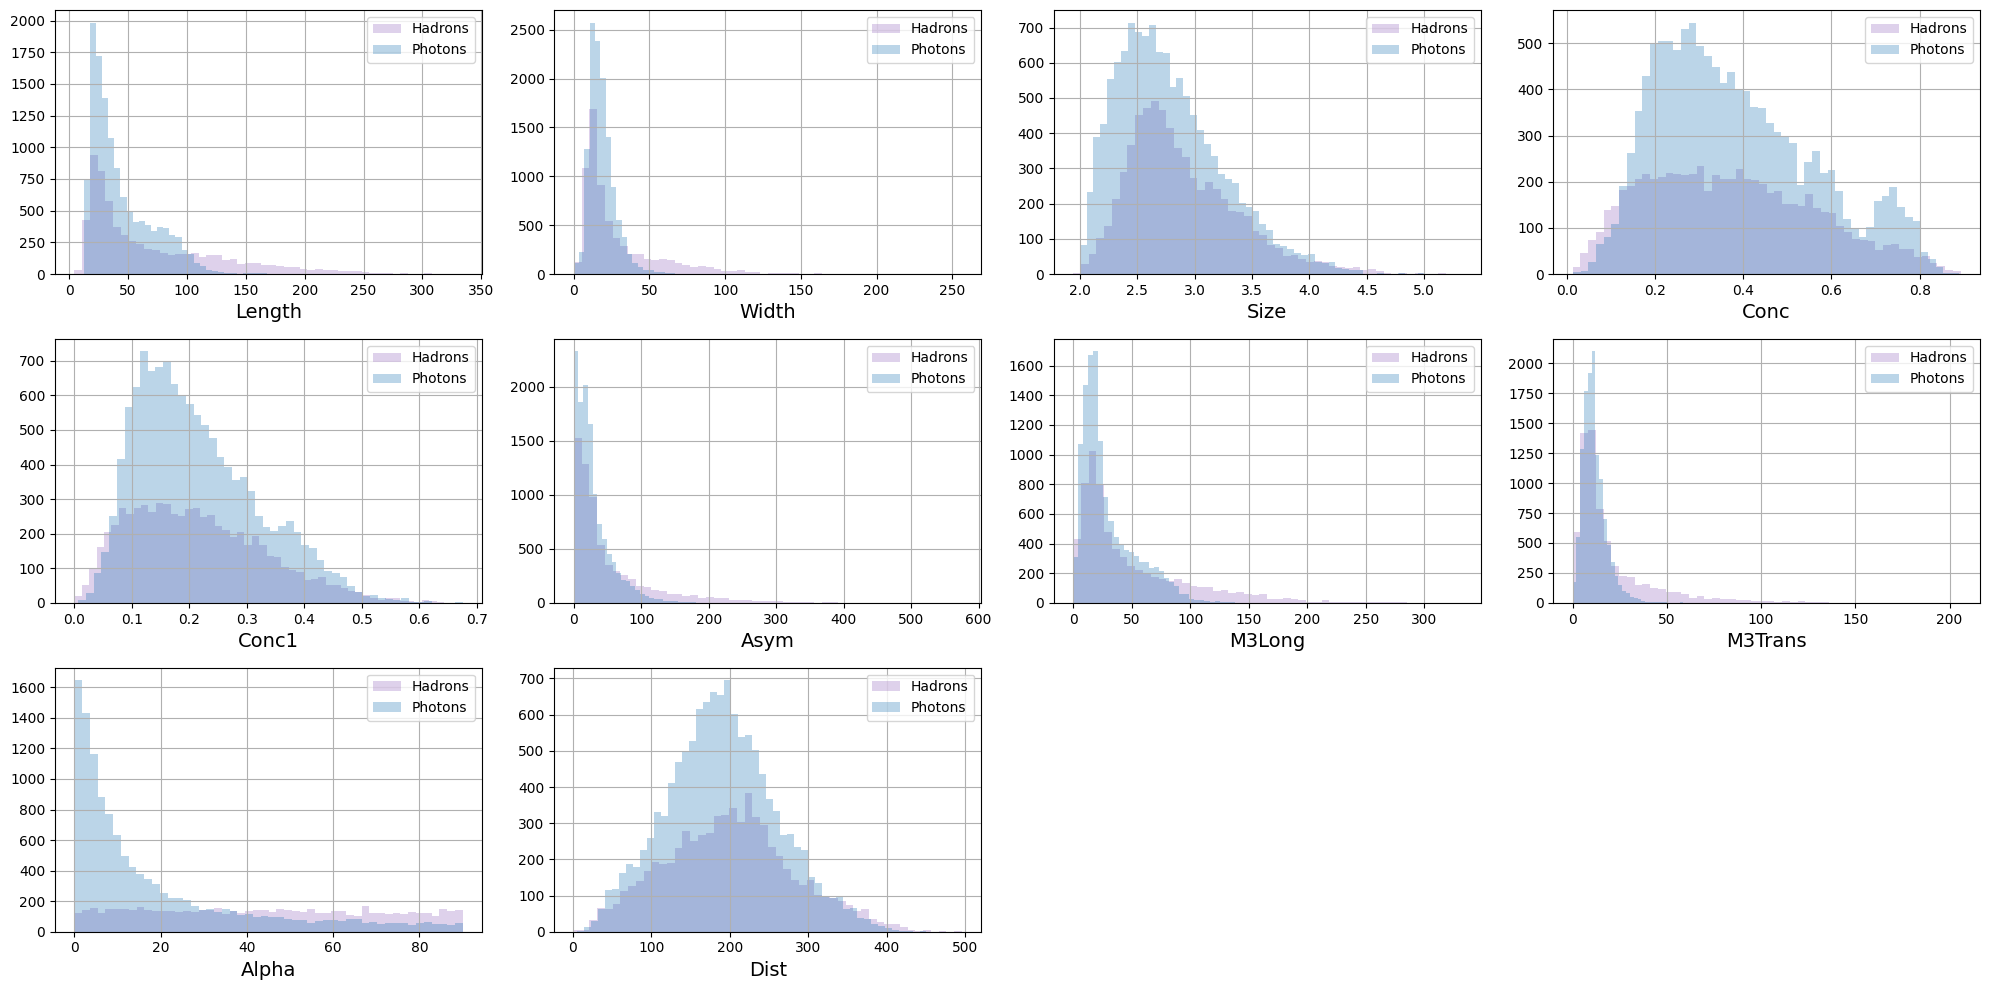

In [ ]:
plot_hists(
    X[y[:, 0] == 0], X[y[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

# Предобработка данных

Из графика видим, что распределения для многих признаков имеют тяжелые хвосты. Это делает обучение генеративных моделей тяжелее. Поэтому нужно как-то преобразовать данные, чтобы убрать эти тяжелые хвосты.

# Обучающая и тестовая выборки

In [7]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.5, shuffle=True, random_state=11
)

## Задание 1 (0.2 балла)

Проиллюстрируйте распределение целевой переменной внутри train и test выборки. Совпадает ли оно? Есть ли идеи почему так?

__Подсказка__: посмотрите на клеточку с разделением данных

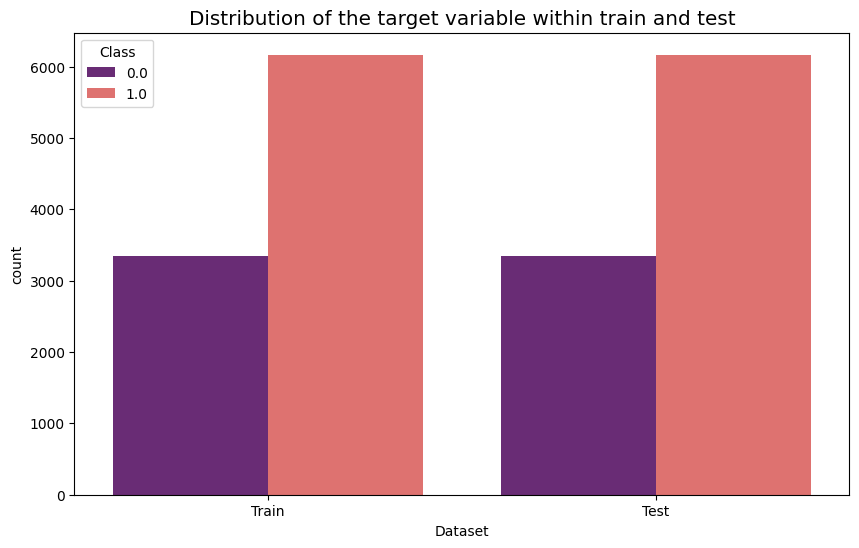

In [8]:
plt.figure(figsize=(10, 6))
plt.title('Distribution of the target variable within train and test', size='x-large')

sns.countplot(data=pd.concat([pd.DataFrame({'Class': y_train[:, 0], 'Dataset': 'Train'}), pd.DataFrame({'Class': y_test[:, 0], 'Dataset': 'Test'})]), x='Dataset', hue='Class', palette='magma');


**Ответ:** распределение целевой переменной внутри train и test выборок совпадают, потому что при разбиении мы использовали stratify=y, за счет чего и сохранили одинакоовое распределение.

## Задание 2 (0.8 балл)

Используя функцию `sklearn.preprocessing.QuantileTransformer` трансформируйте входные данные `X_train` и `X_test`. Это преобразование делает так, чтобы распределение каждого параметра было нормальным. Описание функции доступно по [ссылке](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html). Используйте значение параметра `output_distribution='normal'`.

In [9]:
from sklearn.preprocessing import QuantileTransformer

In [10]:
quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=11)

X_train = quantile_transformer.fit_transform(X_train)
X_test = quantile_transformer.transform(X_test)

In [ ]:
X_train

array([[ 0.19444036,  0.27687113,  0.74471576, ..., -1.36973741,
         0.56382138, -1.65199188],
       [ 1.61411594,  2.10046365,  1.98543233, ...,  1.183988  ,
         1.5491558 ,  0.08762459],
       [ 0.18329836,  0.36231874, -0.05725964, ..., -0.49486454,
        -0.91746935,  0.68953181],
       ...,
       [-0.18274685,  0.370971  ,  0.43157858, ..., -0.18135892,
         0.34340938, -1.53387002],
       [ 0.83765789,  0.65276666,  1.06471524, ...,  0.41458365,
        -0.53900918,  1.19245261],
       [-0.47040248, -0.36924235, -0.42442006, ..., -0.09675374,
        -0.65487791, -0.44285629]])

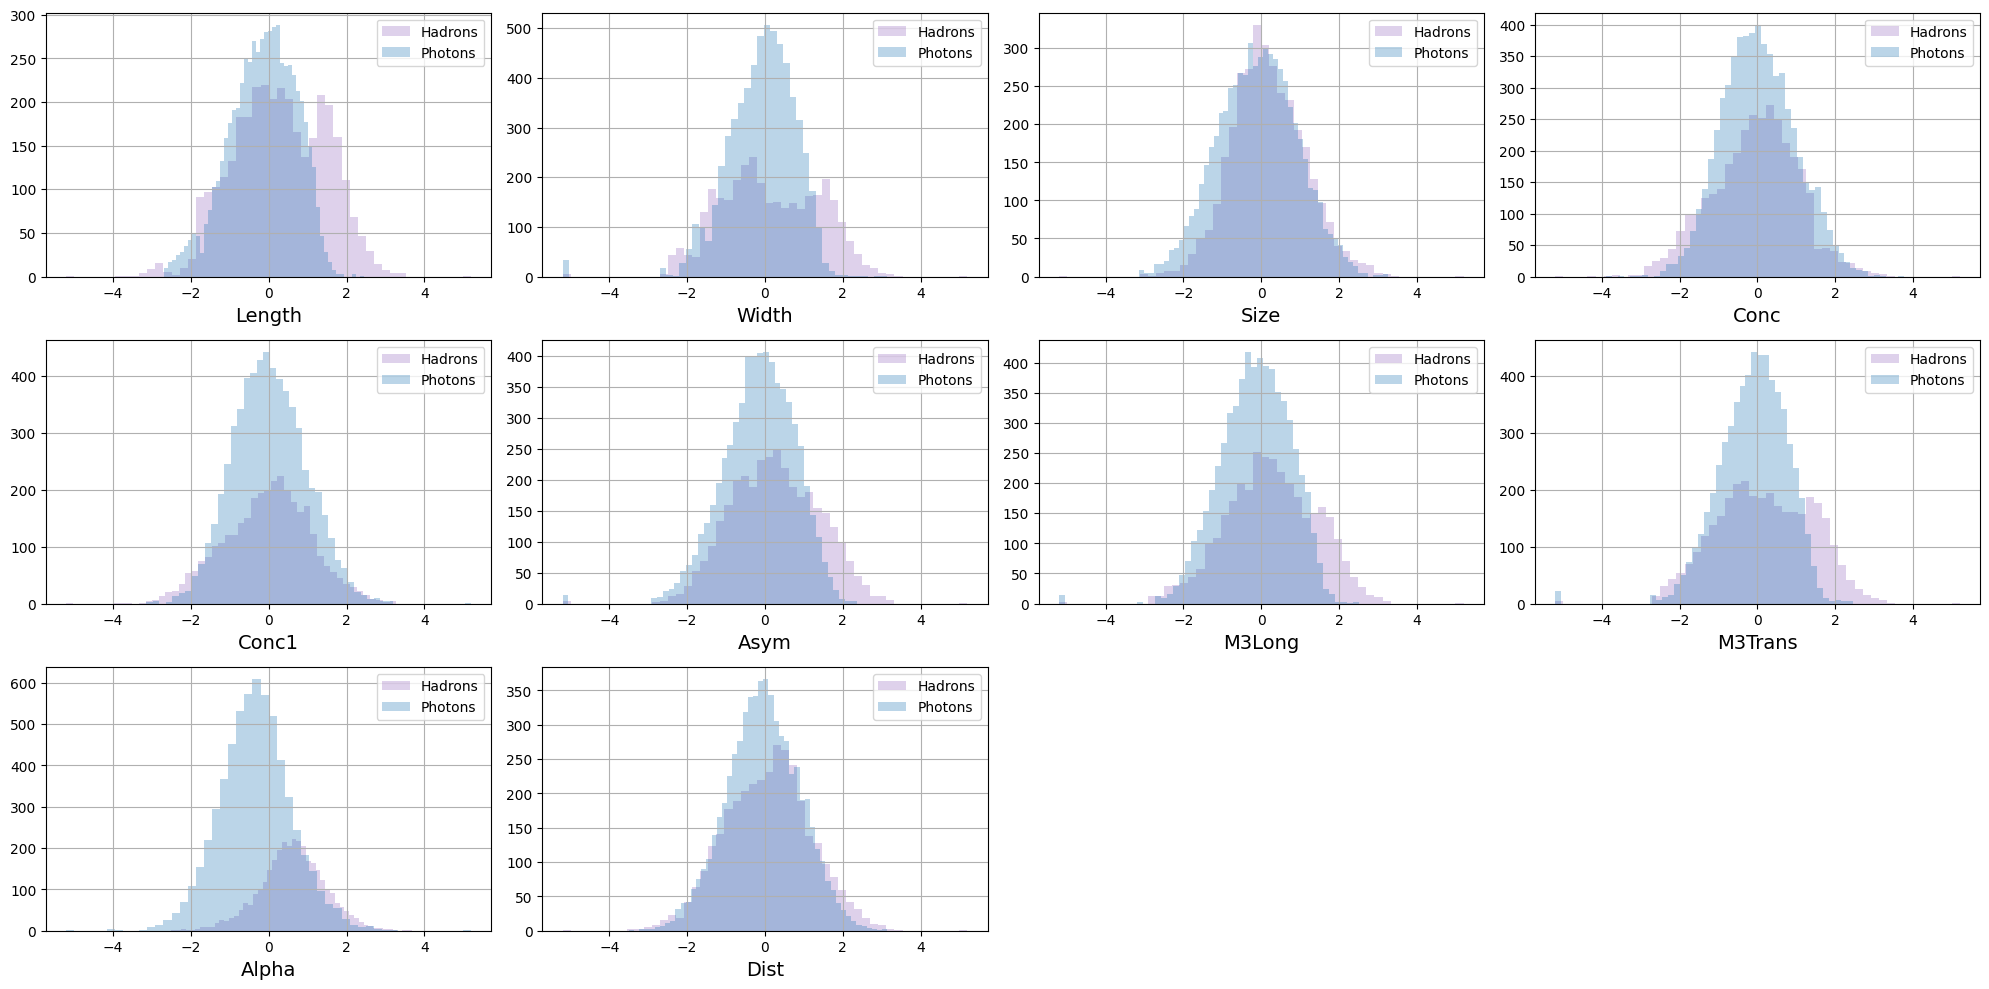

In [ ]:
plot_hists(
    X_train[y_train[:, 0] == 0],
    X_train[y_train[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)

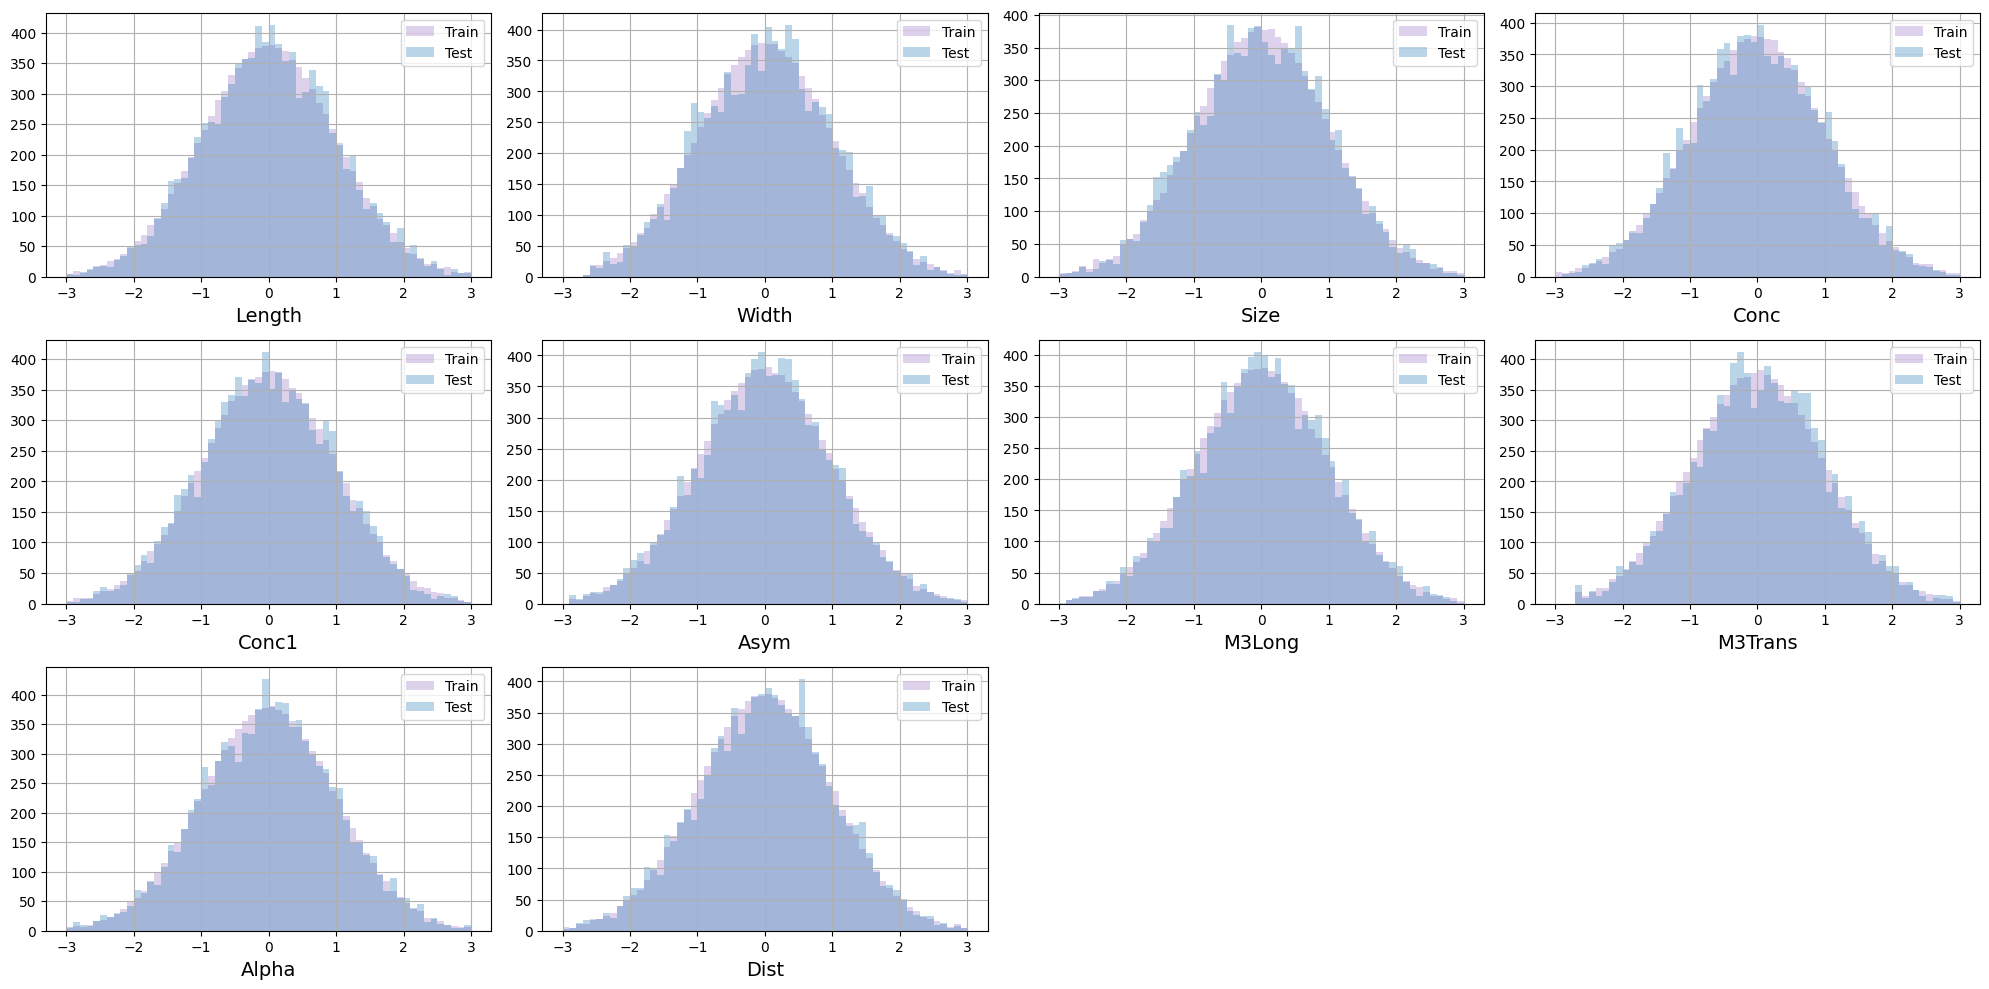

In [ ]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test")

# Conditional WGAN

Мы будем использовать `Conditional WGAN`. В качестве условия `y` мы будем использовать метку класса: **0** - адрон, **1** - фотон. Таким образом, мы будем сообщать генератору для какой частицы нужно генерировать параметры изображения.


Генератор $\hat{x} = G(z, y)$ будет принимать на вход шумовой вектор $z$ и вектор условий $y$, а выдавать будет сгенерированный (фейковый) вектор параметров $\hat{x}$.

Дискриминатор $D(x, y)$ будет принимать на вход вектор параметров $x$ и вектор условий $y$, а возвращать будет рациональное число.

Обучать `Conditional WGAN` будем с такой функцией потерь:

$$L(G, D) = -\frac{1}{n} \sum_{x_i \in X, y_i \in y} D(x_i, y_i) + \frac{1}{n} \sum_{z_i \in Z, y_i \in y} D(G(z_i, y_i), y_i) \to \max_G \min_D$$

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
DEVICE

device(type='cuda')

## Задание 3 (0.75 балла)

Реализуйте нейронную сеть для генератора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [13]:
class Generator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Generator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, n_outputs))

    def forward(self, z, y):
        zy = torch.cat((z.to(DEVICE), y.to(DEVICE)), dim=1) # при исходном коде возникали ошибки из-за несвопадения устройств, перевела все на гпу
        return self.net(zy)

## Задание 4 (0.5 балл)

Реализуйте функцию для генерации новый объектов $X$ по вектору условий $y$.

In [26]:
def generate(generator, y, latent_dim):
    generator.eval() # на всякий случай, чтобы точно не считала градиенты
    z = torch.normal(0, 1, (y.shape[0], latent_dim)).to(DEVICE)
    y = torch.tensor(y, dtype=torch.float32).to(DEVICE)

    with torch.no_grad():
        X_fake = generator(z, y).cpu().detach().numpy() # наверное, detach было бы достаточно, но пусть лучше так

    return X_fake

## Задание 5 (0.75 балла)

Реализуйте нейронную сеть для дискриминатора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

Какая функция активации должна быть в конце работы модели и почему? А она вообще тут должна быть? Обоснуйте свой выбор.

In [16]:
class Discriminator(nn.Module):
    def __init__(self, n_inputs):
        super(Discriminator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )

    def forward(self, x, y):
        xy = torch.cat((x, y), dim=1)
        return self.net(xy)

**Ответ:** по идее тут не нужно делать функцию активации в конце модели, потому что для WGAN нужно, чтобы дискриминатор мог выдавать любые числа (это из-за того, что используется расстояние Вассерштейна), а если использовать всякие сигмоиды или reLU последним слоем, выход дискриминатора будет ограничен.

## Задание 6 (0.5 балла)


Реализуйте функцию, которая принимала бы на вход набор сгенерированных и настоящих объектов, разбивала на train и test с учетом баланса классов (real и fake объектов), с соотношением 3 к 1, обучала модель логистической регрессии и градиентного бустинга, которые учились бы отличать настоящие объекты от фальшивых, после чего выводила бы accuracy score на отложенной выборке у обоих моделей.

Ответьте на вопрос: какое значение accuracy score нас бы удовлетворило больше всего? Почему?

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

In [18]:
def other_agent_score(X_real, y_real, X_fake, y_fake):
    X = np.vstack((X_real, X_fake))
    y = np.hstack((y_real, y_fake))  # 1 для настоящих, 0 для фейковых

    # надеюсь, я правильно поняла, и "с соотношением 3 к 1" значит 1/4 на тест, 3/4 на трейн
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=11)

    lin_reg = LogisticRegression()
    lin_reg.fit(X_train, y_train)
    lin_reg_score = accuracy_score(y_test, lin_reg.predict(X_test))
    print("Linear regression score: " + str(lin_reg_score))

    boosting = GradientBoostingClassifier(random_state=11)
    boosting.fit(X_train, y_train)
    boosting_score = accuracy_score(y_test, boosting.predict(X_test))
    print("Boosting score: " + str(boosting_score))

**Ответ:** в идеале accuracy д.б. равна 0.5, т.к. это будет значит, что сгенерированные объекты не отличить от настоящих, их получится только лишь случайно угадать.

## Задание 7 (1.5 балла)

Реализуйте класс для обучения генеративной модели.

- Уточнение 1: Нужно ограничивать веса дискриминатора. Для этого используйте `p.data.clamp_(-0.01, 0.01)`, где `p` веса дискриминатора. Зачем это делать можно посмотреть в оригинальной статье <https://arxiv.org/pdf/1701.07875.pdf>.
- Подсказка 1: `n_critic` - число итераций обучения дискриминатора на одну итерацию обучения генератора.
- Подсказка 2: Используйте `X_tensor = torch.tensor(X_numpy, dtype=torch.float, device=DEVICE)` для перевода numpy в тензор.

In [19]:
import torch
from torch.utils.data import TensorDataset, DataLoader

In [20]:
class Fitter(object):
    def __init__(
        self,
        generator,
        discriminator,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        n_critic=5,
    ):
        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr)
        self.opt_disc = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)

        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)

    def fit(self, X, y):
        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.generator.train(True)
        self.discriminator.train(True)

        self.loss_history = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):
                split_idx = real_batch.size(0) // 2 # разделяяю батч на две части: для дискриминатора и генератора

                real_batch_d, cond_batch_d = real_batch[:split_idx], cond_batch[:split_idx]
                real_batch_g, cond_batch_g = real_batch[split_idx:], cond_batch[split_idx:]

                for _ in range(self.n_critic):

                    Z_noise = torch.normal(0, 1, (real_batch_d.size(0), self.latent_dim)).to(DEVICE)
                    X_fake = self.generator(Z_noise, cond_batch_d)

                    real_score = self.discriminator(real_batch_d, cond_batch_d)
                    fake_score = self.discriminator(X_fake.detach(), cond_batch_d)

                    loss_disc = -torch.mean(real_score) + torch.mean(fake_score)

                    self.opt_disc.zero_grad()
                    loss_disc.backward()
                    self.opt_disc.step()

                    for p in self.discriminator.parameters():
                        p.data.clamp_(-0.01, 0.01)

                Z_noise = torch.normal(0, 1, (real_batch_g.size(0), self.latent_dim)).to(DEVICE)
                X_fake = self.generator(Z_noise, cond_batch_g)

                fake_score = self.discriminator(X_fake, cond_batch_g)

                loss_gen = -torch.mean(fake_score)

                self.opt_gen.zero_grad()
                loss_gen.backward()
                self.opt_gen.step()

            # caiculate and store loss after an epoch
            Z_noise = torch.normal(0, 1, (len(X_real), self.latent_dim)).to(DEVICE)
            X_fake = self.generator(Z_noise, y_cond)
            loss_epoch = torch.mean(self.discriminator(X_real, y_cond)) - torch.mean(
                self.discriminator(X_fake, y_cond)
            )
            self.loss_history.append(loss_epoch.detach().cpu())

            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов
            # И запустите работу фукнции other_agent_score
            X_reals = X_real[:1000].cpu().numpy()
            y_reals = np.ones(1000)

            X_fakes = X_fake[:1000].detach().cpu().numpy()
            y_fakes = np.zeros(1000)

            print(f"---Epoch {epoch + 1}/{self.n_epochs}---")
            other_agent_score(X_reals, y_reals, X_fakes, y_fakes)

        # Turn off training
        self.generator.train(False)
        self.discriminator.train(False)

## Обучение
Обучим модель на данных.

In [21]:
%%time
latent_dim = 10
generator = Generator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])
discriminator = Discriminator(n_inputs=X_train.shape[1] + y.shape[1])

fitter = Fitter(
    generator,
    discriminator,
    batch_size=50,
    n_epochs=100, #100
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
fitter.fit(X_train, y_train)

---Epoch 1/100---
Linear regression score: 0.628
Boosting score: 0.792
---Epoch 2/100---
Linear regression score: 0.584
Boosting score: 0.676
---Epoch 3/100---
Linear regression score: 0.546
Boosting score: 0.652
---Epoch 4/100---
Linear regression score: 0.496
Boosting score: 0.662
---Epoch 5/100---
Linear regression score: 0.524
Boosting score: 0.636
---Epoch 6/100---
Linear regression score: 0.548
Boosting score: 0.656
---Epoch 7/100---
Linear regression score: 0.558
Boosting score: 0.666
---Epoch 8/100---
Linear regression score: 0.538
Boosting score: 0.654
---Epoch 9/100---
Linear regression score: 0.502
Boosting score: 0.602
---Epoch 10/100---
Linear regression score: 0.538
Boosting score: 0.612
---Epoch 11/100---
Linear regression score: 0.59
Boosting score: 0.652
---Epoch 12/100---
Linear regression score: 0.554
Boosting score: 0.618
---Epoch 13/100---
Linear regression score: 0.5
Boosting score: 0.588
---Epoch 14/100---
Linear regression score: 0.552
Boosting score: 0.562
---E

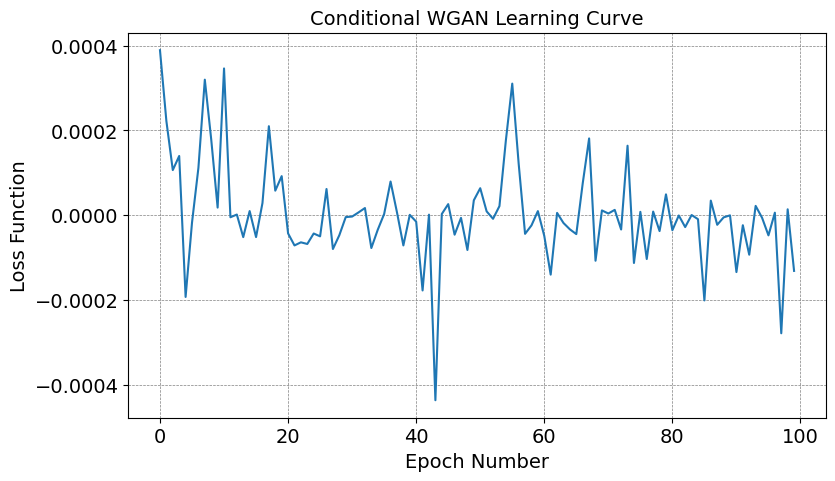

In [22]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional WGAN Learning Curve", size=14)
plt.grid(True, linestyle="--", linewidth=0.5, color="0.5") # вместо b=1 использую True из-за возникновения ошибки
plt.show()

В целом вроде неплохо работает, прыгает, конечно, но это же классическая история для генеративки.  

## Задание 8 (0.5 балла)

Теперь сгенерируем фейковые матрицы `X_fake_train` и `X_fake_test`. Сравним их с матрицами реальных объектов `X_train` и `X_test`. Перед сравнением результатов сделайте обратное квантильное преобразование с помощью трансформера, который вы обучили в задании 2.

In [27]:
X_fake_train = generate(fitter.generator, y_train, latent_dim)

In [28]:
X_fake_train_ = quantile_transformer.inverse_transform(X_fake_train)

In [29]:
X_train_ = quantile_transformer.inverse_transform(X_train)

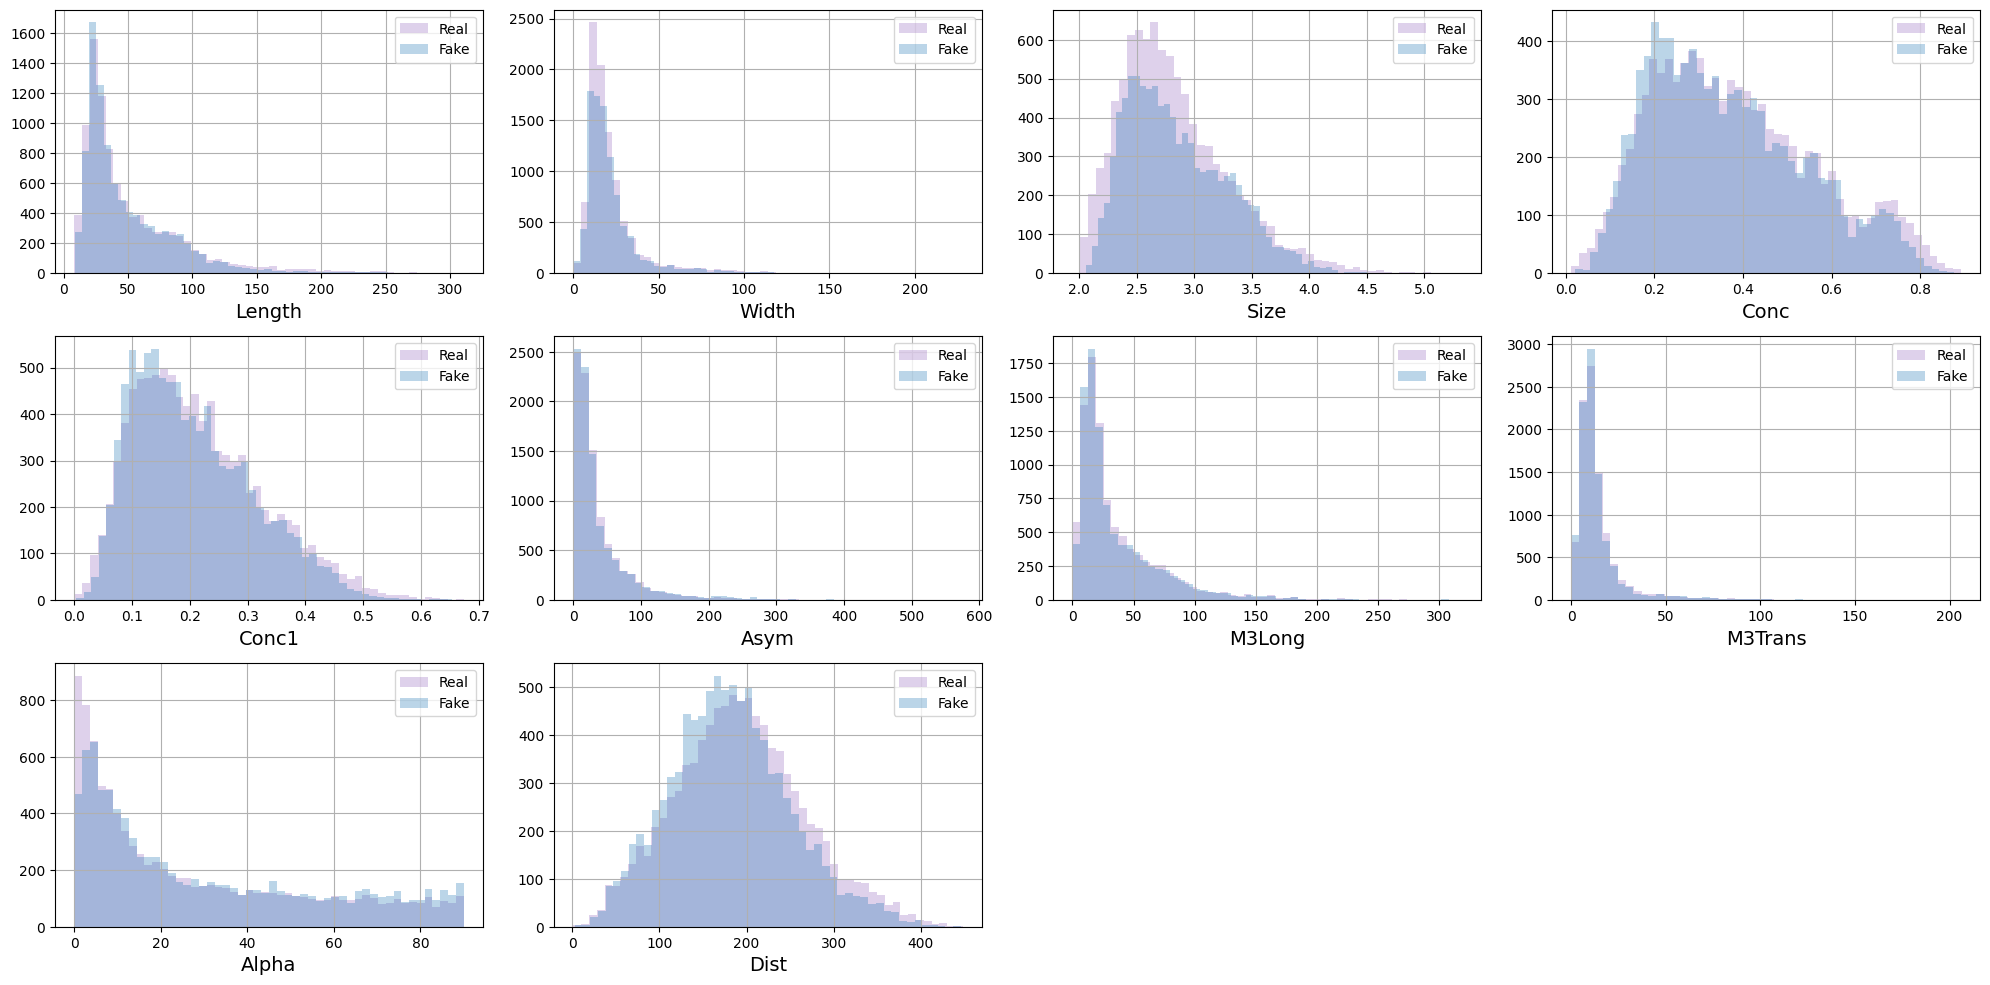

In [30]:
plot_hists(X_train_, X_fake_train_, names, label1="Real", label2="Fake", bins=50)

In [31]:
X_fake_test = generate(fitter.generator, y_test, latent_dim)

In [32]:
X_fake_test_ = quantile_transformer.inverse_transform(X_fake_test)

In [33]:
X_test_ = quantile_transformer.inverse_transform(X_test)

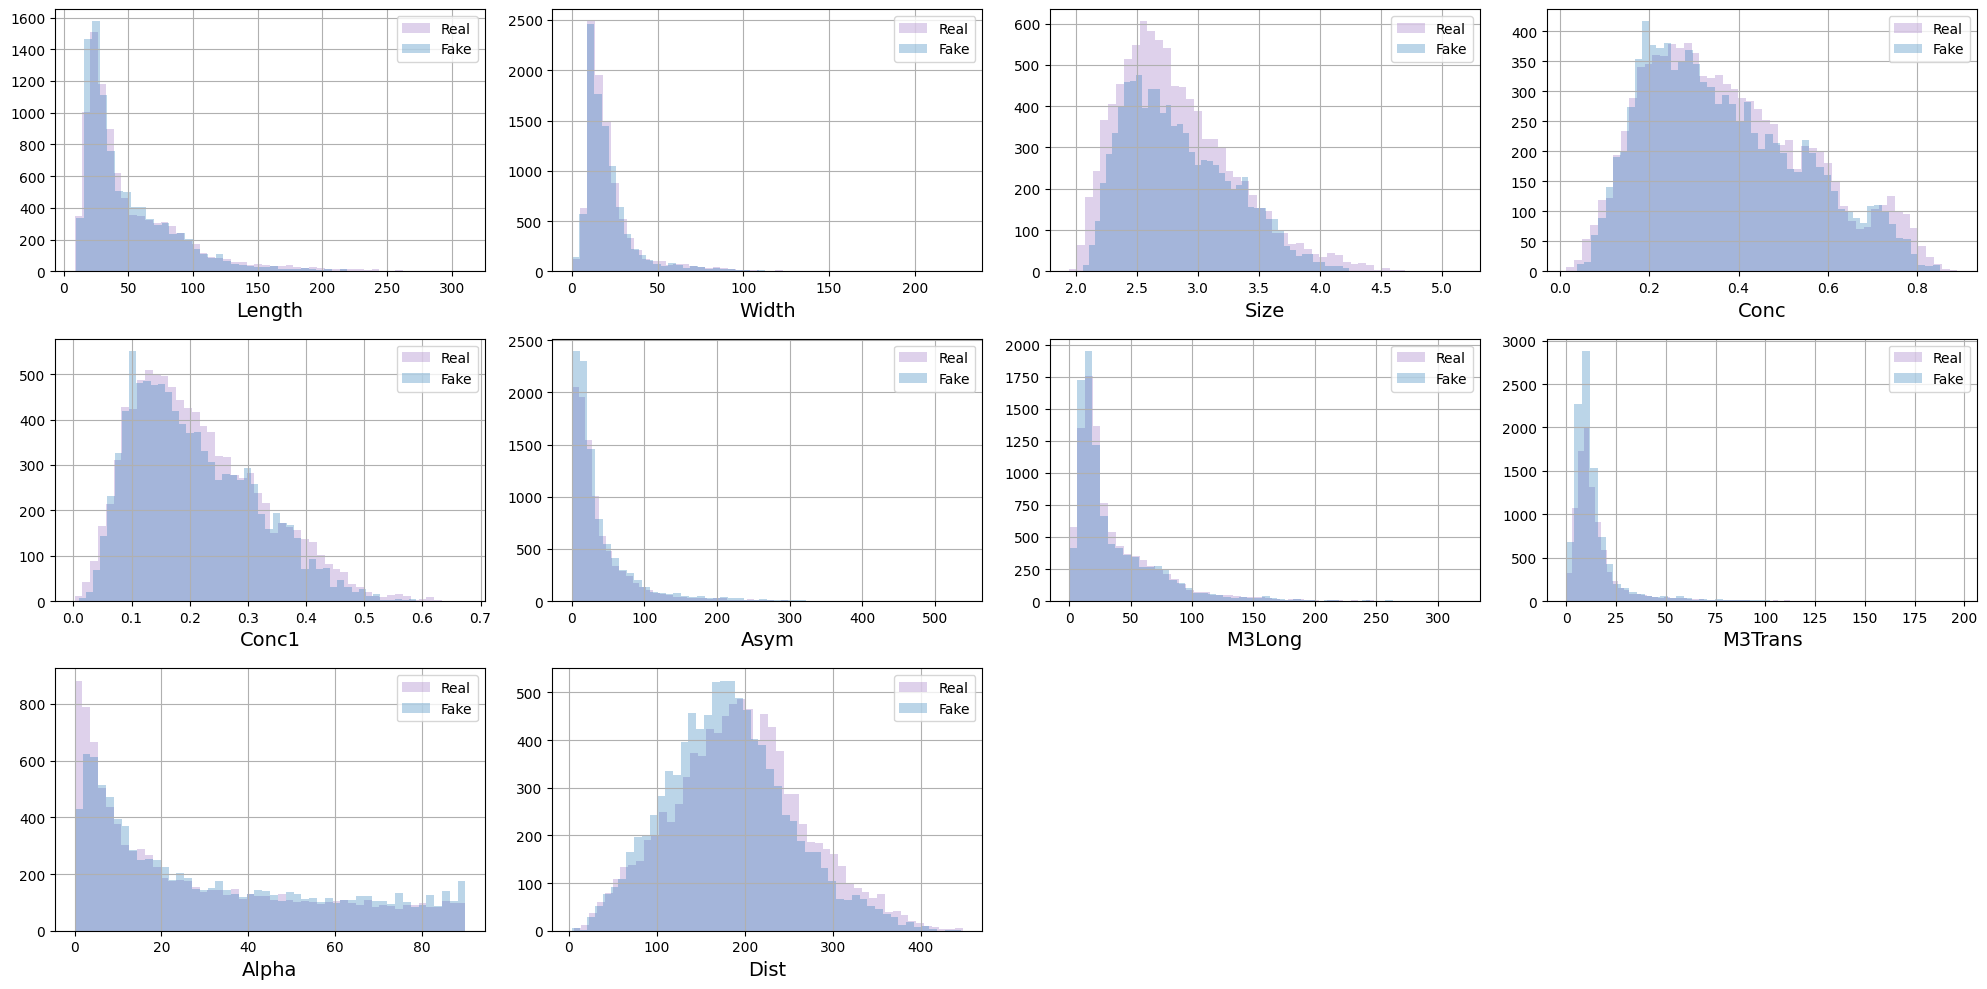

In [34]:
plot_hists(X_test_, X_fake_test_, names, label1="Real", label2="Fake", bins=50)

## Ответьте на вопросы:
- Похожи ли фейковые объекты на реальные?
- Точно ли хорошая идея сравнивать их на глаз?


**Ответ:** фейковые объекты достаточно похожи на реальные, но насколько именно - точно не скажешь, поэтому мало смысла сравнивать их визуально на глаз.

## Измерение качества генерации

<center><img src="img/clf.png" width="600"></center>

Измерим сходство распределений классификатором.

In [35]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train_, X_train_), axis=0)
XX_test = np.concatenate((X_fake_test_, X_test_), axis=0)

yy_train = np.array([0] * len(X_fake_train_) + [1] * len(X_train_))
yy_test = np.array([0] * len(X_fake_test_) + [1] * len(X_test_))

In [36]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [37]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.7488287496364997


## Задание 9 (0.5 балла)

Опишите ваш эксперимент. Как вы оцениваете полученные результаты? Как вы думаете, какое значение ROC AUC нас удовлетворяет больше всего? Почему?


**Ответ:** особых экспериментов в этот раз я не проводила, архитектура полностью основана на подсказках, гиперпараметры оставила дефолтные. И полученное ROC AUC = 0.7529 указывает на то, что классификатор может отличать реальные объекты от сгенерированных, так что может быть и стоило поработать над архитектурой и гиперпапаметрами (но в целом модель все же работает).

Как уже писала ранее, идеальным значением ROC-AUC для задачи генерации было бы 0.5, потому что тогда бы сгенерированные объекты были неотличимы от реальных.

# Диффузионные модели.

Давайте теперь проведем такой же экперимент с простой диффузионной моделью.

## Задание 10 (0.5 балла)

Воспользуйтесь [DDPMScheduler](https://huggingface.co/docs/diffusers/api/schedulers/ddpm), возьмите 1000 шагов и подумайте, надо ли указать ещё какой-то параметр.

__Подсказка__: Посмотрите на распределения выше и почитайте описание шедулера в документации. Один из параметров - наследие от использования в генерации картинок, а у нас не картинки.

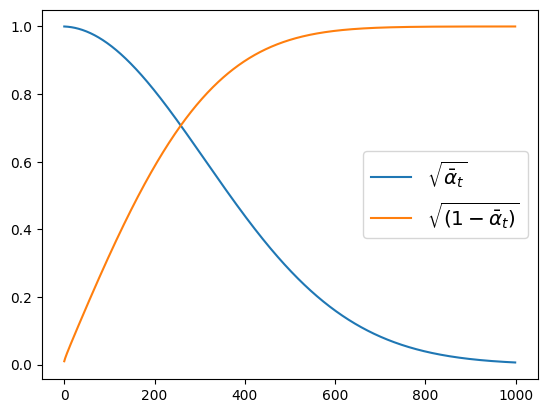

In [38]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    clip_sample=False  # отключаем, т.к. у нас не картинки, остальное все по умолчанию
)

plt.plot(
    noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$"
);
plt.plot(
    (1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5,
    label=r"$\sqrt{(1 - \bar{\alpha}_t)}$",
);
plt.legend(fontsize="x-large")

## Задание 11 (0.5 балла)

Реализуйте нейронную сеть. В качестве архитектуры можете взять модель генератора. В процессе экспериментов попробуйте изменять архитектуру модели для улучшения качества сгенерированных объектов (Кстати, как вы будете качество измерять?).

- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [ ]:
# вариант 1 (как в задании)
class DiffusionGenerator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DiffusionGenerator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, n_outputs)
        )

    def forward(self, z, t, y):
        # Склею z, t ("раздутое" до размерности батча), y при помощи torch.cat по 2 измерению
        zty = torch.cat([z, t.view(-1, 1), y], dim=1)
        return self.net(zty)

In [ ]:
# вариант 2 (добавила слои, поменяла кол-во нейронов на кратное 2)
class DiffusionGenerator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DiffusionGenerator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(n_inputs, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, n_outputs)
        )

    def forward(self, z, t, y):
        # Склею z, t ("раздутое" до размерности батча), y при помощи torch.cat по 2 измерению
        zty = torch.cat([z, t.view(-1, 1), y], dim=1)
        return self.net(zty)

**Ответ:** качество буду измерять как и раннее, т.е. обучать какой-нибудь классификатор отличать фейковые данные от реальных, и чем ближе к 0.5 будет, тем лучше работае.

## Задание 12 (0.5 балла)

Напишите функцию для генерации нового объекта с помощью обученной модели.

In [ ]:
def generate_with_diffusion(model, y, latent_dim, scheduler):
    # модель в режиме eval не будет градиенты считать, так что лучше включить
    model.eval()

    batch_size = y.shape[0]

    y = torch.tensor(y, dtype=torch.float, device=DEVICE)
    z = torch.randn((batch_size, latent_dim), device=DEVICE)

    with torch.no_grad():
        for t in reversed(range(scheduler.num_train_timesteps)):
            timesteps = torch.full((batch_size,), t, dtype=torch.long, device=DEVICE)
            noise_pred = model(z, timesteps, y)
            z = scheduler.step(noise_pred, t, z).prev_sample

    return z.cpu().numpy()

## Задание 13 (2 балла)

Напишите класс обучения диффузионной модели и обучите модель, после чего опишите полученные результаты. В качестве подсказки - опирайтесь на семинар по диффузионным моделям. Вы можете изменять некоторые части кода для вашего удобства, но оставляйте в таком случаи комментарии, пожалуйста.

In [ ]:
class DiffusionFitter(object):
    def __init__(
        self,
        model,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        n_critic=5,
    ):

        self.model = model
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.model.parameters(), lr=self.lr)

        # добавляю сюда шедулер как из 10 задания
        self.scheduler = DDPMScheduler(
            num_train_timesteps=1000,
            clip_sample=False
        )

        self.model.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.model.train(True)

        self.loss_history = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            loss_epoch = 0
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):
                # мне кажется, тут (как и в предыдущем задании) нужно нормальное распределение
                noise = torch.normal(0, 1, (real_batch.size(0), self.latent_dim)).to(DEVICE)
                # случайный вектор из integer
                timesteps = torch.randint(0, self.scheduler.num_train_timesteps, (real_batch.size(0),)).long().to(DEVICE)

                noisy_x = self.scheduler.add_noise(real_batch, noise, timesteps)
                pred = self.model(noisy_x, timesteps, cond_batch)

                loss = torch.nn.functional.mse_loss(pred, noise) # mse как в семинаре

                self.opt_gen.zero_grad()
                loss.backward()
                self.opt_gen.step()

                loss_epoch += loss.item()

            # caiculate and store loss after an epoch
            self.loss_history.append(loss_epoch / len(dataset_real))

            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов
            # И запустите работу фукнции other_agent_score

            X_fakes = generate_with_diffusion(self.model, y[:1000], self.latent_dim, self.scheduler)
            y_fakes = np.zeros(1000)

            X_reals = X_real[:1000].cpu().numpy()
            y_reals = np.ones(1000)

            print(f"---Epoch {epoch + 1}/{self.n_epochs}---")
            print(f"Loss: {self.loss_history[-1]}") # решила тоже выводить, раз сохраняем:)
            other_agent_score(X_reals, y_reals, X_fakes, y_fakes)

        # Turn off training
        self.model.train(False)

Обучим модель на данных, указав количество входов.

У вас есть скрытое пространство и его размер, есть таймстепы и есть условие. Как легко догадаться, размер входа будет больше, чем просто размер скрытого пространства.

In [ ]:
# обновляем данные после работы с WGAN
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.5, shuffle=True, random_state=11
)

quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=11)

X_train = quantile_transformer.fit_transform(X_train)
X_test = quantile_transformer.transform(X_test)

In [ ]:
%%time
latent_dim = 10
model = DiffusionGenerator(n_inputs=latent_dim + 2, n_outputs=X_train.shape[1])

diffusionFitter = DiffusionFitter(
    model,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    #n_critic=5, для диффузионной не нужно
)
diffusionFitter.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 1/100---
Loss: 0.017421596809892623
Linear regression score: 0.992


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Boosting score: 0.988


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 2/100---
Loss: 0.012803943726291917
Linear regression score: 0.954


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Boosting score: 1.0


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 3/100---
Loss: 0.010677334158578506
Linear regression score: 0.964
Boosting score: 1.0


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 4/100---
Loss: 0.009735656524180864
Linear regression score: 0.894
Boosting score: 1.0


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 5/100---
Loss: 0.008689613641875274
Linear regression score: 0.854
Boosting score: 0.996


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 6/100---
Loss: 0.007852909918463193
Linear regression score: 0.886
Boosting score: 0.99


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 7/100---
Loss: 0.007197767959126163
Linear regression score: 0.954
Boosting score: 0.974


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 8/100---
Loss: 0.006457971296538564
Linear regression score: 0.756
Boosting score: 0.906


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 9/100---
Loss: 0.006007990656277609
Linear regression score: 0.8
Boosting score: 0.878


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 10/100---
Loss: 0.005866561217388269
Linear regression score: 0.804
Boosting score: 0.868


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 11/100---
Loss: 0.005569845842262172
Linear regression score: 0.86
Boosting score: 0.882


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 12/100---
Loss: 0.005485301409171332
Linear regression score: 0.782
Boosting score: 0.852


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 13/100---
Loss: 0.0052503632649889
Linear regression score: 0.83
Boosting score: 0.884


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 14/100---
Loss: 0.005200059058538371
Linear regression score: 0.762
Boosting score: 0.868


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 15/100---
Loss: 0.005158007616563049
Linear regression score: 0.778
Boosting score: 0.852


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 16/100---
Loss: 0.005173050337221344
Linear regression score: 0.786
Boosting score: 0.834


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 17/100---
Loss: 0.005148197536588843
Linear regression score: 0.736
Boosting score: 0.828


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 18/100---
Loss: 0.005055580074290748
Linear regression score: 0.838
Boosting score: 0.89


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 19/100---
Loss: 0.00496348006617509
Linear regression score: 0.862
Boosting score: 0.882


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 20/100---
Loss: 0.004884273898087591
Linear regression score: 0.792
Boosting score: 0.822


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 21/100---
Loss: 0.004883540188257125
Linear regression score: 0.884
Boosting score: 0.892


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 22/100---
Loss: 0.004963850665575071
Linear regression score: 0.688
Boosting score: 0.76


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 23/100---
Loss: 0.004827110111306017
Linear regression score: 0.762
Boosting score: 0.832


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 24/100---
Loss: 0.0049230046209915454
Linear regression score: 0.8
Boosting score: 0.86


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 25/100---
Loss: 0.004821688678707109
Linear regression score: 0.756
Boosting score: 0.806


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 26/100---
Loss: 0.004931899491544778
Linear regression score: 0.836
Boosting score: 0.84


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 27/100---
Loss: 0.004889012567628445
Linear regression score: 0.774
Boosting score: 0.802


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 28/100---
Loss: 0.004758489169532944
Linear regression score: 0.918
Boosting score: 0.922


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 29/100---
Loss: 0.004905007892414598
Linear regression score: 0.8
Boosting score: 0.846


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 30/100---
Loss: 0.004864496488582448
Linear regression score: 0.766
Boosting score: 0.798


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 31/100---
Loss: 0.004790904877470369
Linear regression score: 0.808
Boosting score: 0.812


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 32/100---
Loss: 0.004799824342774041
Linear regression score: 0.75
Boosting score: 0.778


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 33/100---
Loss: 0.004864764218262693
Linear regression score: 0.76
Boosting score: 0.804


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 34/100---
Loss: 0.004788669537200536
Linear regression score: 0.656
Boosting score: 0.686


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 35/100---
Loss: 0.004705845255925703
Linear regression score: 0.764
Boosting score: 0.79


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 36/100---
Loss: 0.004790311482207131
Linear regression score: 0.758
Boosting score: 0.796


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 37/100---
Loss: 0.004602941699114508
Linear regression score: 0.94
Boosting score: 0.924


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 38/100---
Loss: 0.004744697001015476
Linear regression score: 0.79
Boosting score: 0.812


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 39/100---
Loss: 0.004697575384886107
Linear regression score: 0.77
Boosting score: 0.806


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 40/100---
Loss: 0.004727967503381703
Linear regression score: 0.782
Boosting score: 0.826


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 41/100---
Loss: 0.004652385075981058
Linear regression score: 0.714
Boosting score: 0.784


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 42/100---
Loss: 0.0046143156927780146
Linear regression score: 0.728
Boosting score: 0.744


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 43/100---
Loss: 0.004578090649485964
Linear regression score: 0.85
Boosting score: 0.838


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 44/100---
Loss: 0.004730639973367427
Linear regression score: 0.764
Boosting score: 0.794


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 45/100---
Loss: 0.004556412730839977
Linear regression score: 0.768
Boosting score: 0.794


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 46/100---
Loss: 0.004769724201642126
Linear regression score: 0.736
Boosting score: 0.75


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 47/100---
Loss: 0.004624235400485441
Linear regression score: 0.704
Boosting score: 0.786


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 48/100---
Loss: 0.004634131022682952
Linear regression score: 0.818
Boosting score: 0.802


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 49/100---
Loss: 0.0046486412861495114
Linear regression score: 0.722
Boosting score: 0.772


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 50/100---
Loss: 0.004625987436242409
Linear regression score: 0.748
Boosting score: 0.772


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 51/100---
Loss: 0.004758007938804185
Linear regression score: 0.76
Boosting score: 0.786


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 52/100---
Loss: 0.004621001059575286
Linear regression score: 0.678
Boosting score: 0.754


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 53/100---
Loss: 0.004661789565463673
Linear regression score: 0.744
Boosting score: 0.784


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 54/100---
Loss: 0.00475900369832443
Linear regression score: 0.73
Boosting score: 0.77


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 55/100---
Loss: 0.004695522039345261
Linear regression score: 0.84
Boosting score: 0.828


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 56/100---
Loss: 0.004658946803879662
Linear regression score: 0.692
Boosting score: 0.78


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 57/100---
Loss: 0.004523667370357975
Linear regression score: 0.754
Boosting score: 0.794


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 58/100---
Loss: 0.004713382777982204
Linear regression score: 0.684
Boosting score: 0.714


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 59/100---
Loss: 0.004686053811751706
Linear regression score: 0.778
Boosting score: 0.806


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 60/100---
Loss: 0.004596598476140155
Linear regression score: 0.734
Boosting score: 0.754


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 61/100---
Loss: 0.004614058780933405
Linear regression score: 0.706
Boosting score: 0.726


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 62/100---
Loss: 0.004719826361295678
Linear regression score: 0.916
Boosting score: 0.85


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 63/100---
Loss: 0.004479678988958132
Linear regression score: 0.734
Boosting score: 0.754


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 64/100---
Loss: 0.00473697985259015
Linear regression score: 0.826
Boosting score: 0.832


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 65/100---
Loss: 0.0045770046995515954
Linear regression score: 0.834
Boosting score: 0.85


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 66/100---
Loss: 0.004520063107729459
Linear regression score: 0.698
Boosting score: 0.746


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 67/100---
Loss: 0.004561781677193196
Linear regression score: 0.662
Boosting score: 0.682


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 68/100---
Loss: 0.004629207608514279
Linear regression score: 0.702
Boosting score: 0.736


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 69/100---
Loss: 0.004635908687340348
Linear regression score: 0.796
Boosting score: 0.806


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 70/100---
Loss: 0.004624862945418253
Linear regression score: 0.788
Boosting score: 0.788


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 71/100---
Loss: 0.004550066275363465
Linear regression score: 0.81
Boosting score: 0.824


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 72/100---
Loss: 0.004562880598658893
Linear regression score: 0.616
Boosting score: 0.668


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 73/100---
Loss: 0.004599275537125069
Linear regression score: 0.69
Boosting score: 0.738


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 74/100---
Loss: 0.004558324181601076
Linear regression score: 0.756
Boosting score: 0.762


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 75/100---
Loss: 0.004685321777714289
Linear regression score: 0.772
Boosting score: 0.776


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 76/100---
Loss: 0.004545544710727144
Linear regression score: 0.704
Boosting score: 0.734


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 77/100---
Loss: 0.004599294388425839
Linear regression score: 0.88
Boosting score: 0.862


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 78/100---
Loss: 0.004556004019095694
Linear regression score: 0.768
Boosting score: 0.794


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 79/100---
Loss: 0.0045568036324845
Linear regression score: 0.656
Boosting score: 0.676


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 80/100---
Loss: 0.004528525184162282
Linear regression score: 0.692
Boosting score: 0.736


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 81/100---
Loss: 0.004581833380880667
Linear regression score: 0.77
Boosting score: 0.78


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 82/100---
Loss: 0.004365300103536289
Linear regression score: 0.69
Boosting score: 0.746


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 83/100---
Loss: 0.004501230160771359
Linear regression score: 0.802
Boosting score: 0.804


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 84/100---
Loss: 0.0044852666392311315
Linear regression score: 0.822
Boosting score: 0.836


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 85/100---
Loss: 0.004608724433948315
Linear regression score: 0.63
Boosting score: 0.704


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 86/100---
Loss: 0.0045019312055642425
Linear regression score: 0.716
Boosting score: 0.758


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 87/100---
Loss: 0.004483850874578665
Linear regression score: 0.738
Boosting score: 0.742


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 88/100---
Loss: 0.004565835527127724
Linear regression score: 0.666
Boosting score: 0.684


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 89/100---
Loss: 0.004461670163960111
Linear regression score: 0.684
Boosting score: 0.678


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 90/100---
Loss: 0.004552870453751551
Linear regression score: 0.69
Boosting score: 0.684


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 91/100---
Loss: 0.004681616303923253
Linear regression score: 0.716
Boosting score: 0.764


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 92/100---
Loss: 0.004486132592558234
Linear regression score: 0.738
Boosting score: 0.746


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 93/100---
Loss: 0.004562739896285421
Linear regression score: 0.814
Boosting score: 0.818


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 94/100---
Loss: 0.004464560736961796
Linear regression score: 0.86
Boosting score: 0.864


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 95/100---
Loss: 0.004456923267442721
Linear regression score: 0.83
Boosting score: 0.852


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 96/100---
Loss: 0.004504884849963504
Linear regression score: 0.614
Boosting score: 0.676


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 97/100---
Loss: 0.004376916231667832
Linear regression score: 0.722
Boosting score: 0.762


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 98/100---
Loss: 0.0044927255470858015
Linear regression score: 0.672
Boosting score: 0.714


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 99/100---
Loss: 0.004636609985970047
Linear regression score: 0.628
Boosting score: 0.676


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 100/100---
Loss: 0.004451455139838057
Linear regression score: 0.722
Boosting score: 0.748
CPU times: user 3min 47s, sys: 12.3 s, total: 3min 59s
Wall time: 3min 51s


In [ ]:
%%time
# эксперимент с измененной архитектурой
latent_dim = 10
model = DiffusionGenerator(n_inputs=latent_dim + 2, n_outputs=X_train.shape[1])

diffusionFitter = DiffusionFitter(
    model,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    #n_critic=5, для диффузионной не нужно
)
diffusionFitter.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 1/100---
Loss: 0.010877713394967289
Linear regression score: 0.936
Boosting score: 0.952


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 2/100---
Loss: 0.0071593695399513
Linear regression score: 0.958
Boosting score: 0.97


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 3/100---
Loss: 0.005713922775631573
Linear regression score: 0.81
Boosting score: 0.842


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 4/100---
Loss: 0.005343370578329144
Linear regression score: 0.942
Boosting score: 0.946


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 5/100---
Loss: 0.005408531648315466
Linear regression score: 0.878
Boosting score: 0.902


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 6/100---
Loss: 0.0052834817350349466
Linear regression score: 1.0
Boosting score: 0.998


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 7/100---
Loss: 0.005228080768941204
Linear regression score: 0.892
Boosting score: 0.88


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 8/100---
Loss: 0.005048067088226164
Linear regression score: 0.88
Boosting score: 0.892


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 9/100---
Loss: 0.005064000617066393
Linear regression score: 0.99
Boosting score: 0.978


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 10/100---
Loss: 0.004924202030358129
Linear regression score: 0.936
Boosting score: 0.92


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 11/100---
Loss: 0.004848692255127944
Linear regression score: 0.874
Boosting score: 0.884


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 12/100---
Loss: 0.0047206760071742924
Linear regression score: 0.89
Boosting score: 0.892


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 13/100---
Loss: 0.004769733126669903
Linear regression score: 0.842
Boosting score: 0.858


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 14/100---
Loss: 0.004695067217830103
Linear regression score: 0.886
Boosting score: 0.86


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 15/100---
Loss: 0.004767696372968792
Linear regression score: 0.762
Boosting score: 0.788


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 16/100---
Loss: 0.004755451985400809
Linear regression score: 0.766
Boosting score: 0.774


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 17/100---
Loss: 0.004723622304407956
Linear regression score: 0.75
Boosting score: 0.76


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 18/100---
Loss: 0.004676859127014844
Linear regression score: 0.84
Boosting score: 0.854


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 19/100---
Loss: 0.004669564041836906
Linear regression score: 0.72
Boosting score: 0.736


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 20/100---
Loss: 0.004596417083098435
Linear regression score: 0.982
Boosting score: 0.952


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 21/100---
Loss: 0.004663361724932236
Linear regression score: 0.882
Boosting score: 0.888


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 22/100---
Loss: 0.0047165600964887665
Linear regression score: 0.928
Boosting score: 0.924


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 23/100---
Loss: 0.004505141035552782
Linear regression score: 0.82
Boosting score: 0.8


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 24/100---
Loss: 0.004434703255990827
Linear regression score: 0.832
Boosting score: 0.842


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 25/100---
Loss: 0.004588357366221936
Linear regression score: 0.886
Boosting score: 0.852


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 26/100---
Loss: 0.004518168387478208
Linear regression score: 0.68
Boosting score: 0.666


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 27/100---
Loss: 0.004489683987402389
Linear regression score: 0.838
Boosting score: 0.836


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 28/100---
Loss: 0.0045357566503132175
Linear regression score: 0.964
Boosting score: 0.938


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 29/100---
Loss: 0.00453121752001259
Linear regression score: 0.852
Boosting score: 0.864


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 30/100---
Loss: 0.004481489075784553
Linear regression score: 0.834
Boosting score: 0.812


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 31/100---
Loss: 0.004551528054206278
Linear regression score: 0.764
Boosting score: 0.764


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 32/100---
Loss: 0.004548607362369634
Linear regression score: 0.718
Boosting score: 0.714


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 33/100---
Loss: 0.00439606588314259
Linear regression score: 0.714
Boosting score: 0.718


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 34/100---
Loss: 0.004386156720631256
Linear regression score: 0.712
Boosting score: 0.74


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 35/100---
Loss: 0.004298658310176196
Linear regression score: 0.774
Boosting score: 0.756


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 36/100---
Loss: 0.004547326327874458
Linear regression score: 0.8
Boosting score: 0.79


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 37/100---
Loss: 0.0045093992570283915
Linear regression score: 0.822
Boosting score: 0.794


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 38/100---
Loss: 0.004435945970528259
Linear regression score: 0.82
Boosting score: 0.798


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 39/100---
Loss: 0.004397217186655532
Linear regression score: 0.908
Boosting score: 0.884


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 40/100---
Loss: 0.0044699200531849725
Linear regression score: 0.668
Boosting score: 0.696


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 41/100---
Loss: 0.004293883063063637
Linear regression score: 0.708
Boosting score: 0.688


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 42/100---
Loss: 0.004348059423996447
Linear regression score: 0.782
Boosting score: 0.81


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 43/100---
Loss: 0.004305320681238275
Linear regression score: 0.706
Boosting score: 0.688


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 44/100---
Loss: 0.004476531826891984
Linear regression score: 0.852
Boosting score: 0.842


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 45/100---
Loss: 0.004479450368558445
Linear regression score: 0.718
Boosting score: 0.75


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 46/100---
Loss: 0.0043112751280597085
Linear regression score: 0.85
Boosting score: 0.818


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 47/100---
Loss: 0.00429177185800612
Linear regression score: 0.628
Boosting score: 0.646


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 48/100---
Loss: 0.004308579894239092
Linear regression score: 0.774
Boosting score: 0.754


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 49/100---
Loss: 0.004342118612285919
Linear regression score: 0.882
Boosting score: 0.868


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 50/100---
Loss: 0.004335763039053677
Linear regression score: 0.878
Boosting score: 0.864


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 51/100---
Loss: 0.00427147848325949
Linear regression score: 0.786
Boosting score: 0.77


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 52/100---
Loss: 0.004258748874867376
Linear regression score: 0.734
Boosting score: 0.744


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 53/100---
Loss: 0.004364636601521765
Linear regression score: 0.73
Boosting score: 0.704


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 54/100---
Loss: 0.004395674064081675
Linear regression score: 0.968
Boosting score: 0.952


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 55/100---
Loss: 0.004258288441521638
Linear regression score: 0.828
Boosting score: 0.814


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 56/100---
Loss: 0.004325849016820846
Linear regression score: 0.838
Boosting score: 0.844


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 57/100---
Loss: 0.004255599453340193
Linear regression score: 0.768
Boosting score: 0.738


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 58/100---
Loss: 0.004255418311784947
Linear regression score: 0.818
Boosting score: 0.796


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 59/100---
Loss: 0.004435896252984128
Linear regression score: 0.88
Boosting score: 0.858


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 60/100---
Loss: 0.0043011001529628425
Linear regression score: 0.768
Boosting score: 0.792


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 61/100---
Loss: 0.004341060882111077
Linear regression score: 0.624
Boosting score: 0.636


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 62/100---
Loss: 0.004263493395581857
Linear regression score: 0.65
Boosting score: 0.68


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 63/100---
Loss: 0.004230138146319474
Linear regression score: 0.806
Boosting score: 0.788


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 64/100---
Loss: 0.004268594919757763
Linear regression score: 0.696
Boosting score: 0.698


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 65/100---
Loss: 0.004285531094617021
Linear regression score: 0.728
Boosting score: 0.69


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 66/100---
Loss: 0.004287107516037052
Linear regression score: 0.722
Boosting score: 0.702


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 67/100---
Loss: 0.0043635015145774645
Linear regression score: 0.76
Boosting score: 0.73


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 68/100---
Loss: 0.004336254808710953
Linear regression score: 0.71
Boosting score: 0.714


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 69/100---
Loss: 0.004298991007979109
Linear regression score: 0.696
Boosting score: 0.684


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 70/100---
Loss: 0.0043407584002905465
Linear regression score: 0.724
Boosting score: 0.73


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 71/100---
Loss: 0.0042212991676558705
Linear regression score: 0.744
Boosting score: 0.744


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 72/100---
Loss: 0.004206412583276175
Linear regression score: 0.704
Boosting score: 0.726


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 73/100---
Loss: 0.004284936062733081
Linear regression score: 0.83
Boosting score: 0.826


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 74/100---
Loss: 0.00445191722704033
Linear regression score: 0.802
Boosting score: 0.79


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 75/100---
Loss: 0.0042147568872611734
Linear regression score: 0.648
Boosting score: 0.65


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 76/100---
Loss: 0.0041953566996331725
Linear regression score: 0.82
Boosting score: 0.786


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 77/100---
Loss: 0.00431817367469224
Linear regression score: 0.728
Boosting score: 0.718


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 78/100---
Loss: 0.0042107832607285334
Linear regression score: 0.672
Boosting score: 0.674


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 79/100---
Loss: 0.004169187552984079
Linear regression score: 0.678
Boosting score: 0.692


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 80/100---
Loss: 0.0042388453860262845
Linear regression score: 0.906
Boosting score: 0.864


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 81/100---
Loss: 0.004324749289971672
Linear regression score: 0.938
Boosting score: 0.926


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 82/100---
Loss: 0.004233881499771064
Linear regression score: 0.754
Boosting score: 0.732


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 83/100---
Loss: 0.0042025473184264675
Linear regression score: 0.854
Boosting score: 0.796


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 84/100---
Loss: 0.004287142012773628
Linear regression score: 0.866
Boosting score: 0.842


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 85/100---
Loss: 0.004210773159746868
Linear regression score: 0.69
Boosting score: 0.686


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 86/100---
Loss: 0.004181035430994194
Linear regression score: 0.634
Boosting score: 0.654


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 87/100---
Loss: 0.00424858091397115
Linear regression score: 0.652
Boosting score: 0.65


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 88/100---
Loss: 0.004227245598248002
Linear regression score: 0.706
Boosting score: 0.692


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 89/100---
Loss: 0.00429828651288581
Linear regression score: 0.826
Boosting score: 0.79


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 90/100---
Loss: 0.004318087644381478
Linear regression score: 0.82
Boosting score: 0.79


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 91/100---
Loss: 0.004258869470858047
Linear regression score: 0.886
Boosting score: 0.84


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 92/100---
Loss: 0.004126055450908268
Linear regression score: 0.692
Boosting score: 0.684


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 93/100---
Loss: 0.004219905658381219
Linear regression score: 0.752
Boosting score: 0.77


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 94/100---
Loss: 0.0042299783442925456
Linear regression score: 0.644
Boosting score: 0.638


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 95/100---
Loss: 0.004297493468699771
Linear regression score: 0.778
Boosting score: 0.804


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 96/100---
Loss: 0.004324831149994261
Linear regression score: 0.58
Boosting score: 0.606


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 97/100---
Loss: 0.004249343543962726
Linear regression score: 0.76
Boosting score: 0.75


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 98/100---
Loss: 0.004228396127715347
Linear regression score: 0.714
Boosting score: 0.714


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 99/100---
Loss: 0.004136147820924484
Linear regression score: 0.622
Boosting score: 0.642


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


---Epoch 100/100---
Loss: 0.004242882966901226
Linear regression score: 0.656
Boosting score: 0.66
CPU times: user 3min 56s, sys: 11 s, total: 4min 7s
Wall time: 4min 13s


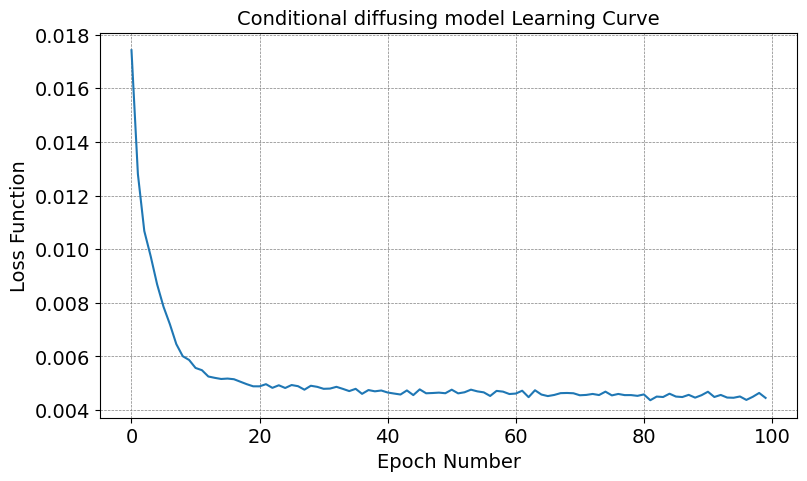

In [ ]:
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(diffusionFitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
plt.grid(True, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

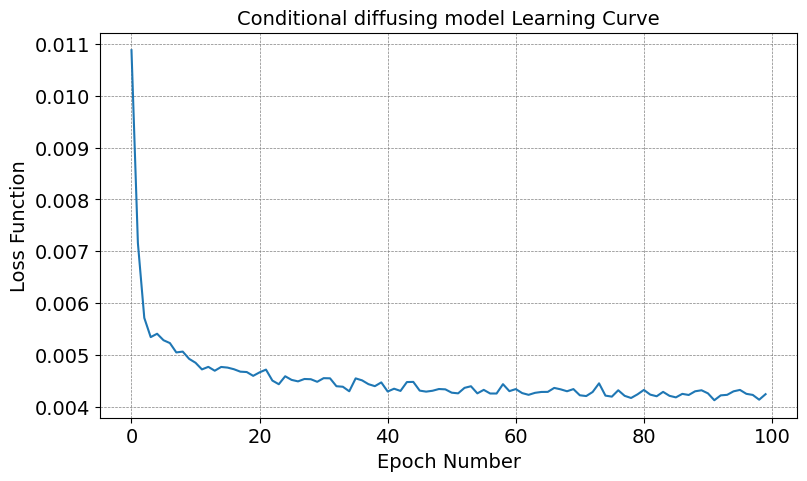

In [ ]:
# эксперимент с измененной архитектурой
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(diffusionFitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
plt.grid(True, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 14 (0.5 балла)
По аналогии с прошлым экспериментом с GAN моделью сгенерируйте выборку фейковых объектов равную размеру тестовой выборки и обучите градиентный бустинг. Обучите модель отличать реальные объекты от фейковых, после чего расчитайте метрики ROC-AUC и accuracy score. Какие получились результаты? Как вы их оцениваете? А в сравнении с GAN моделью?

In [ ]:
# генерируем выборку фейковых объектов равную размеру тестовой выборки, на которой будем проверять качество
X_fake_diffusion = generate_with_diffusion(model, y_test, latent_dim, noise_scheduler)

X_fake_diffusion = quantile_transformer.inverse_transform(X_fake_diffusion)
X_test = quantile_transformer.inverse_transform(X_test)

# собираем реальный и фейковые матрицы в одну
XX = np.vstack([X_test, X_fake_diffusion])
yy = np.hstack([np.ones(len(X_test)), np.zeros(len(X_fake_diffusion))])

XX_train, XX_test, yy_train, yy_test = train_test_split(XX, yy, test_size=0.3, random_state=11)

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_pred = clf.predict(XX_test)
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

# метрики
print(f"ROC-AUC: {roc_auc_score(yy_test, yy_test_proba)}")
print(f"Accuracy: {accuracy_score(yy_test, yy_test_pred)}")

/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


ROC-AUC: 0.8544173041465735
Accuracy: 0.767788293024886


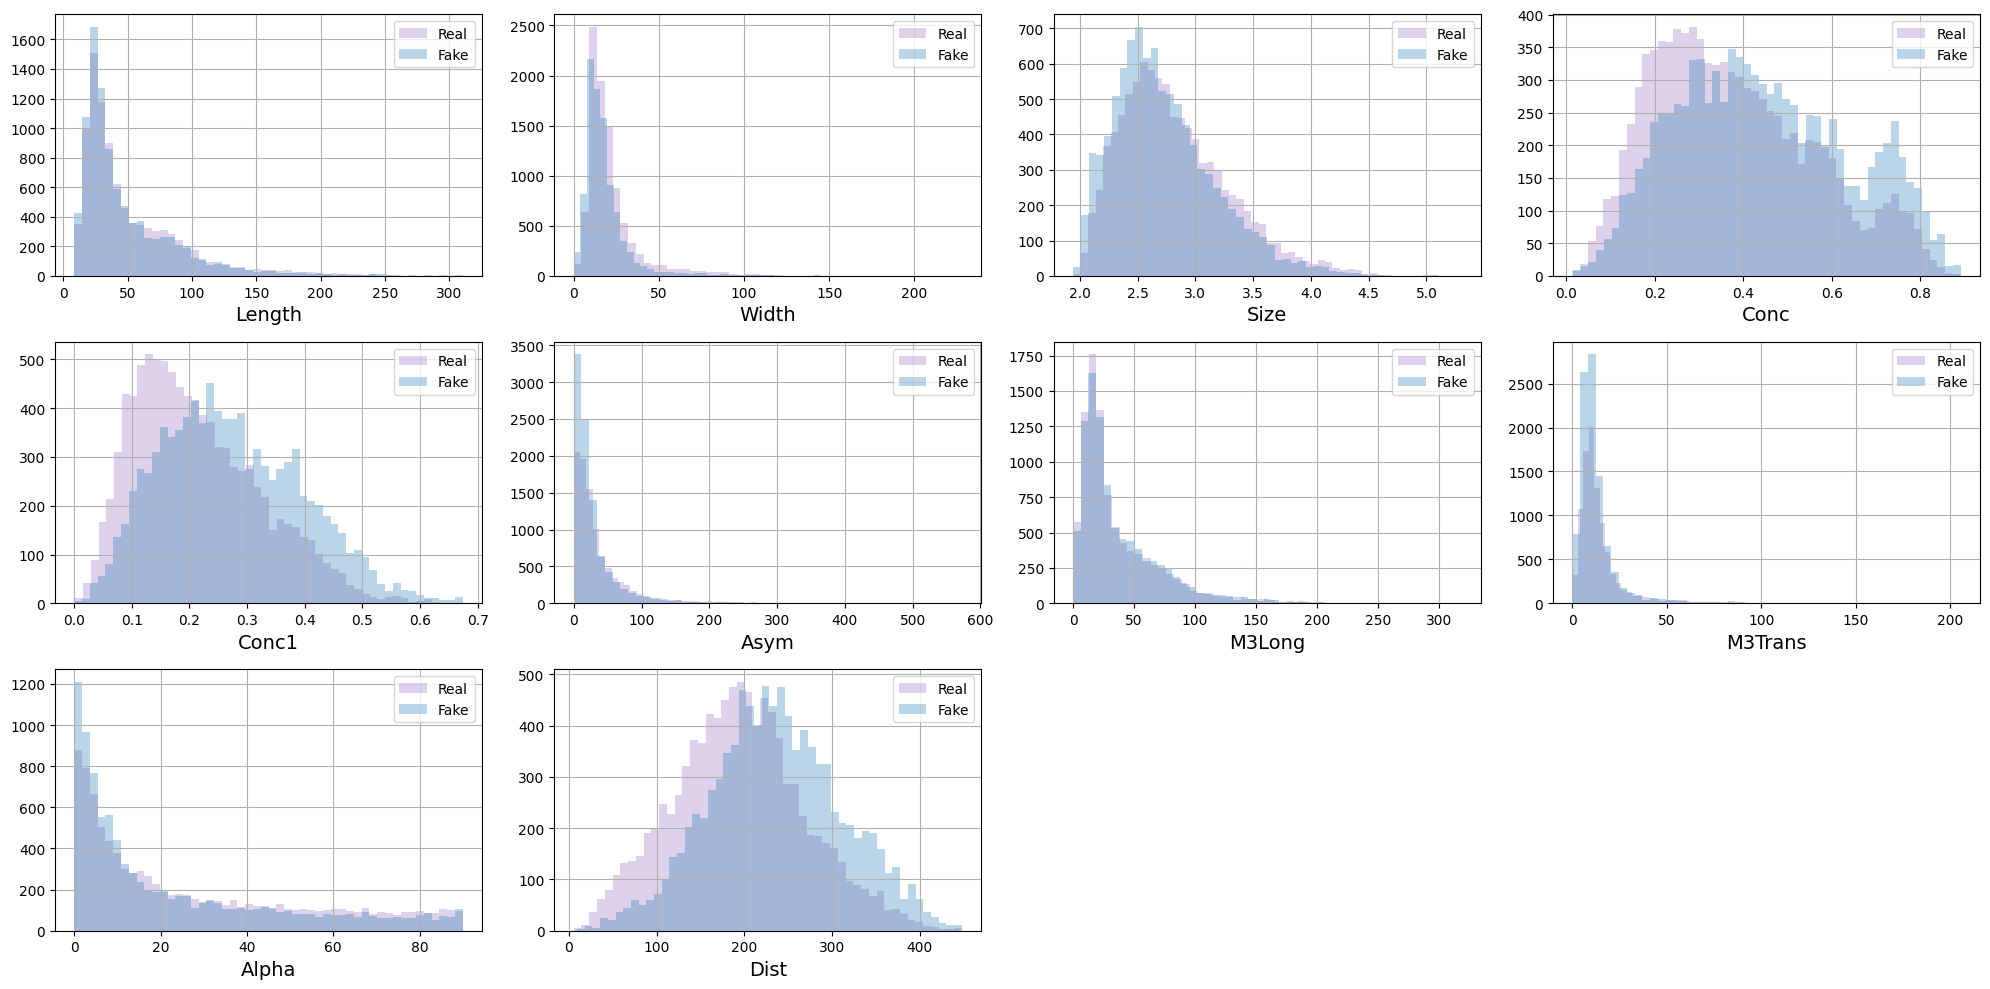

In [ ]:
plot_hists(X_test, X_fake_diffusion, names, label1="Real", label2="Fake", bins=50)

In [ ]:
# эксперимент с измененной архитектурой
# генерируем выборку фейковых объектов равную размеру тестовой выборки, на которой будем проверять качество
X_fake_diffusion = generate_with_diffusion(model, y_test, latent_dim, noise_scheduler)

X_fake_diffusion = quantile_transformer.inverse_transform(X_fake_diffusion)
X_test = quantile_transformer.inverse_transform(X_test)

# собираем реальный и фейковые матрицы в одну
XX = np.vstack([X_test, X_fake_diffusion])
yy = np.hstack([np.ones(len(X_test)), np.zeros(len(X_fake_diffusion))])

XX_train, XX_test, yy_train, yy_test = train_test_split(XX, yy, test_size=0.3, random_state=11)

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_pred = clf.predict(XX_test)
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

# метрики
print(f"ROC-AUC: {roc_auc_score(yy_test, yy_test_proba)}")
print(f"Accuracy: {accuracy_score(yy_test, yy_test_pred)}")

ROC-AUC: 0.7612449489534803
Accuracy: 0.6894497020679986


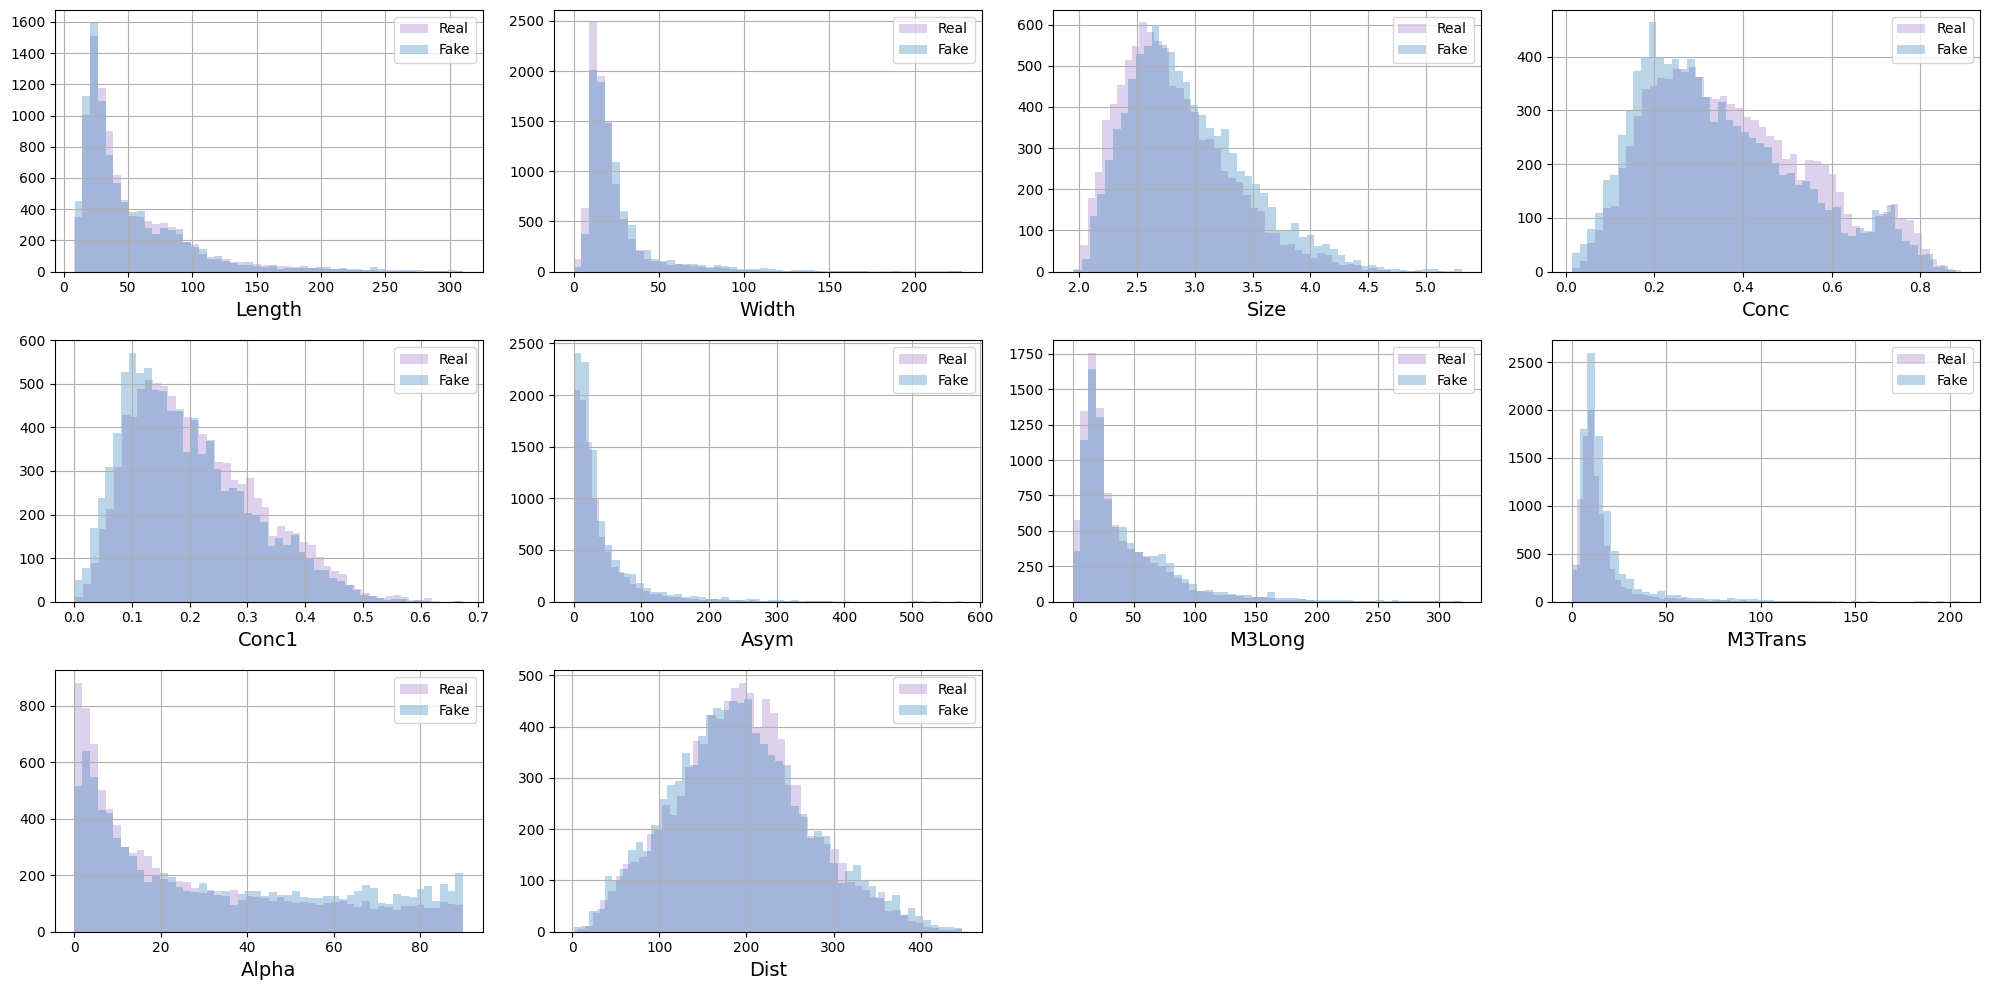

In [ ]:
plot_hists(X_test, X_fake_diffusion, names, label1="Real", label2="Fake", bins=50)

**Ответ:** у меня модель не очень хорошо для диффузионной генерирует фейковые объекты, потому что классификатор легко их отличает от реальных (ROC-AUC = 0.85 и accuracy = 0.77), хотелось бы поближе к 0.5, конечно (╯_╰) Если сравнивать с GAN моделью, она у меня лучше генерирует фейковые объекты (ROC AUC = 0.75).  

UPDATE! Я решила поэксперементировать👉👈 и изменила немного архитектуру, усложнив ее, мне это помогло - модель стала лучше генерировать: ROC-AUC = 0.76, accuracy = 0.69, т.е. теперь фейковые объекты сложнее отличить, но все равно эта моделька хуже WGAN.



# Бонус (2 балла)

Кроме Diffusion и GAN вы изучили еще VAE и NF. В качестве бонуса релизуйте VAE, обучите, и в конце сравните качество теми же методами, что и в основной части ДЗ.

Разбалловка бонуса такая:
- Реализовать VAE - 1 балл
- Обучить VAE - 0.5 балла
- Провести сравнение с GAN и Diffusion аналогично 14 заданию основной части - 0.5 балла

Ниже приведены шаблоны. Они не особо щедры на комментарии, но поскольку задача бонусная, ожидаем, что вы в них разберетесь. Если они вам не нравятся - можете переписать как хотите.

Если же VAE вам кажется слишком скучным, то мы засчитаем реализацию NF, но шаблонов не предоставим. Бонус в таком случае тоже ограничен сверху 2 баллами и разбалловка не изменится.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, n_inputs, lat_size):
        super(Encoder, self).__init__()

        # слои делаю подобные моей изначальной архитектуры WGAN
        self.enc_net =  nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
        )

        self.mu = nn.Linear(100, lat_size)
        self.log_sigma = nn.Linear(100, lat_size)

    def forward(self, x, y):
        z = torch.cat((x, y), dim=1)
        z = self.enc_net(z)
        mu = self.mu(z)
        log_sigma = self.log_sigma(z)
        return mu, log_sigma


class Decoder(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Decoder, self).__init__()

        self.dec_net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, n_outputs),
        )

    def forward(self, z, y):
        z_cond = torch.cat((z, y), dim=1)
        x_rec = self.dec_net(z_cond)
        return x_rec

def generate(decoder, y, latent_dim):
    y = torch.tensor(y, dtype=torch.float, device=DEVICE)
    z = torch.normal(0, 1, (y.size(0), latent_dim)).to(DEVICE)

    with torch.no_grad():
        X_fake = decoder(z, y).cpu().numpy()

    return X_fake

In [ ]:
class VAEFitter(object):
    def __init__(
        self,
        encoder,
        decoder,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        KL_weight=0.001,
    ):

        self.encoder = encoder
        self.decoder = decoder
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.KL_weight = KL_weight

        self.criterion = nn.MSELoss()
        self.opt = torch.optim.RMSprop(
            list(self.encoder.parameters()) + list(self.decoder.parameters()),
            lr=self.lr,
        )

        self.encoder.to(DEVICE)
        self.decoder.to(DEVICE)

    def sample_z(self, mu, log_sigma):
        eps = torch.randn(mu.shape).to(DEVICE)
        return mu + torch.exp(log_sigma / 2) * eps

    def custom_loss(self, x, rec_x, mu, log_sigma):
        KL = torch.mean(
            -0.5 * torch.sum(1 + log_sigma - mu**2 - log_sigma.exp(), dim=1), dim=0
        )
        recon_loss = self.criterion(x, rec_x)
        return KL * self.KL_weight + recon_loss

    def compute_loss(self, x_batch, cond_batch):

        mu, log_sigma = self.encoder(x_batch, cond_batch)
        z = self.sample_z(mu, log_sigma)
        rec_x = self.decoder(z, cond_batch)

        return self.custom_loss(x_batch, rec_x, mu, log_sigma)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.encoder.train(True)
        self.decoder.train(True)

        self.loss_history = []

        # Fit
        for epoch in range(self.n_epochs):
            for i, (x_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                # caiculate loss
                loss = self.compute_loss(x_batch, cond_batch)

                # optimization step
                self.opt.zero_grad()
                loss.backward()
                self.opt.step()

            # caiculate and store loss after an epoch
            loss_epoch = self.compute_loss(X_real, y_cond)
            self.loss_history.append(loss_epoch.detach().cpu())

        # Turn off training
        self.encoder.train(False)
        self.decoder.train(False)

In [ ]:
# обновляем данные после работы с дифуфузионной модели
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.5, shuffle=True, random_state=11
)

quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=11)

X_train = quantile_transformer.fit_transform(X_train)
X_test = quantile_transformer.transform(X_test)

In [ ]:
%%time
latent_dim = 10
n_inputs = X_train.shape[1] + y_train.shape[1]  # Размерность входных данных + условие
n_outputs = X_train.shape[1]  # Размерность выходных данных

# Создание модели
encoder = Encoder(n_inputs, latent_dim)
decoder = Decoder(latent_dim + y_train.shape[1], n_outputs)

# Создание объекта VAEFitter
vae_fitter = VAEFitter(
    encoder,
    decoder,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    KL_weight=0.001,
)

# Обучение модели
vae_fitter.fit(X_train, y_train)

CPU times: user 1min 19s, sys: 892 ms, total: 1min 20s
Wall time: 1min 20s


In [ ]:
# генерируем выборку фейковых объектов равную размеру тестовой выборки, на которой будем проверять качество
X_fake_vae = generate(decoder, y_test, latent_dim)

X_fake_vae = quantile_transformer.inverse_transform(X_fake_vae)
X_test = quantile_transformer.inverse_transform(X_test)

# собираем реальный и фейковые матрицы в одну
XX = np.vstack([X_test, X_fake_vae])
yy = np.hstack([np.ones(len(X_test)), np.zeros(len(X_fake_vae))])

XX_train, XX_test, yy_train, yy_test = train_test_split(XX, yy, test_size=0.3, random_state=11)

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_pred = clf.predict(XX_test)
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

# метрики
print(f"ROC-AUC: {roc_auc_score(yy_test, yy_test_proba)}")
print(f"Accuracy: {accuracy_score(yy_test, yy_test_pred)}")

ROC-AUC: 0.7855337167531009
Accuracy: 0.7003154574132492


Ну тоже не очень хорошо генерирует, если честно😞 Хуже WGAN и диффузионной модели с уложненной архитектурой.